## Application: Effect of Swedish Speed Limits on Accidents
---

### Description:

An experiment was performed in Sweden in 1961–2 to assess the effect of a speed limit on the motorway accident rate. The experiment was conducted on 92 days in each year, matched so that day j in 1962 was comparable to day j in 1961. On some days the speed limit was in effect and enforced, while on other days there was no speed limit and cars tended to be driven faster. The speed limit days tended to be in contiguous blocks.

### Variables:

+ year - 1961 or 1962.
+ day - of year.
+ limit - was there a speed limit?
+ y - traffic accident count for that day.

### Source:

Svensson, A. (1981) On the goodness-of-fit test for the multiplicative Poisson model. Annals of Statistics, 9, 697–704.

### Reference:

Venables, W. N. and Ripley, B. D. (2002) Modern Applied Statistics with S-PLUS. Fourth Edition. Springer.

https://vincentarelbundock.github.io/Rdatasets/datasets.html


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as st
from IPython.display import display
pd.set_option('future.no_silent_downcasting', True)

In [2]:
traffic = pd.read_csv('Traffic.csv', index_col=0)
display(traffic)

,year,day,limit,y
1,1961,1,no,9
2,1961,2,no,11
3,1961,3,no,9
4,1961,4,no,20
5,1961,5,no,31
...,...,...,...,...
180,1962,88,yes,16
181,1962,89,yes,25
182,1962,90,yes,14
183,1962,91,yes,15


In [3]:
traffic['limit'] = traffic['limit'].replace({'yes':1, 'no':0})
display(traffic)

,year,day,limit,y
1,1961,1,0,9
2,1961,2,0,11
3,1961,3,0,9
4,1961,4,0,20
5,1961,5,0,31
...,...,...,...,...
180,1962,88,1,16
181,1962,89,1,25
182,1962,90,1,14
183,1962,91,1,15


### Poisson regression model of traffic accidents

$$
  p(y_{i}|\lambda_{i}) = \frac{\lambda_{i}^{y_{i}} e^{-\lambda_{i}}}{y_{i}!},\quad
  \log\lambda_{i} = \text{constant} + \beta\ \text{speed limit}.
$$


In [4]:
y = traffic['y'].to_numpy(dtype='float64')
limit = traffic['limit'].to_numpy(dtype='float64')
X = np.stack((np.ones(len(y)), limit), axis=1)

In [5]:
k = X.shape[1]
b0, A0 = np.zeros(k), 0.01 * np.eye(k)
poisson_regression_model = pm.Model()
with poisson_regression_model:
    y_data = pm.Data('y_data', y)
    X_data = pm.Data('X_data', X)
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = X_data @ b
    likelihood = pm.Poisson('y', mu=pm.math.exp(idx), observed=y_data)

In [6]:
n_draws, n_chains, n_tune = 5000, 4, 1000
with poisson_regression_model:
    # trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=rng) # PyMC default sampler (very slow)
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, target_accept=0.9, random_seed=123, nuts_sampler='numpyro') # numpyro (much faster but does not work on Colab)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [7]:
results = pm.summary(trace, hdi_prob=0.95)
var_names = ['constant', 'speed limit']
results.index = var_names
sim_param = dict([(var, trace.posterior['b'].values[:, :, index]) for index, var in enumerate(var_names)])
display(results)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,3.141,0.019,3.105,3.179,0.0,0.0,8171.0,10435.0,1.0
speed limit,-0.202,0.034,-0.269,-0.137,0.0,0.0,8271.0,10460.0,1.0


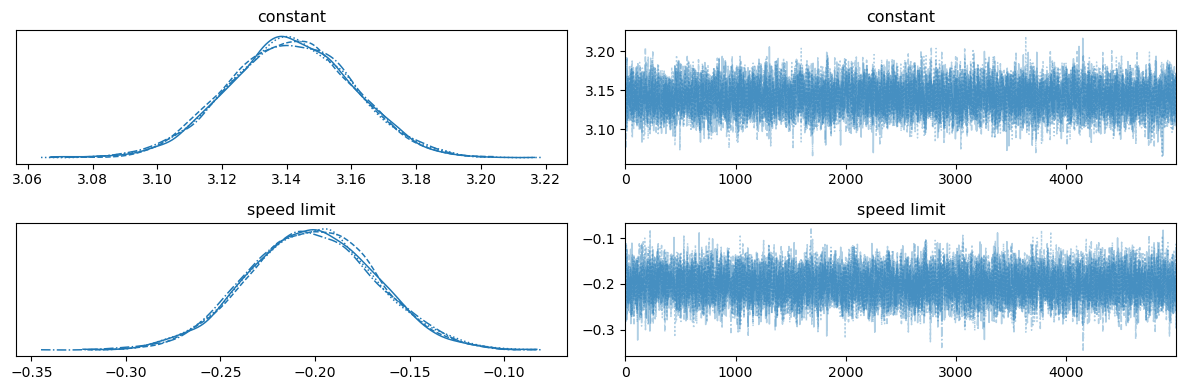

In [8]:
pm.plot_trace(sim_param)
plt.tight_layout()
plt.show()

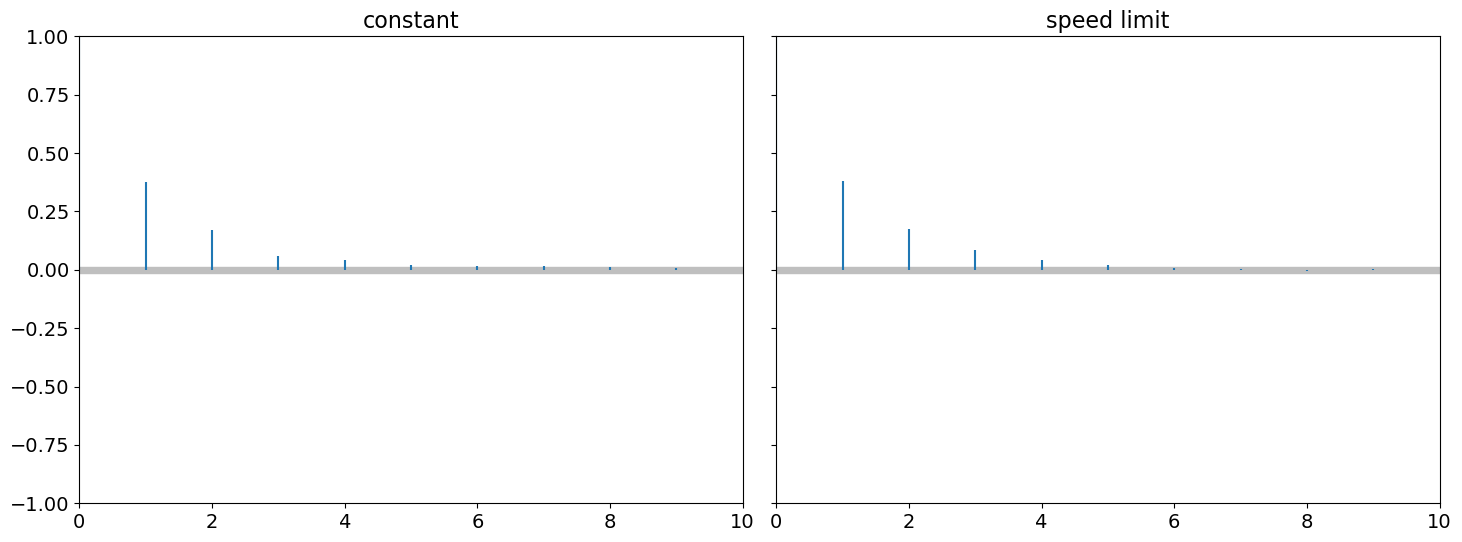

In [9]:
pm.plot_autocorr(sim_param, max_lag=10, combined=True)
plt.tight_layout()
plt.show()

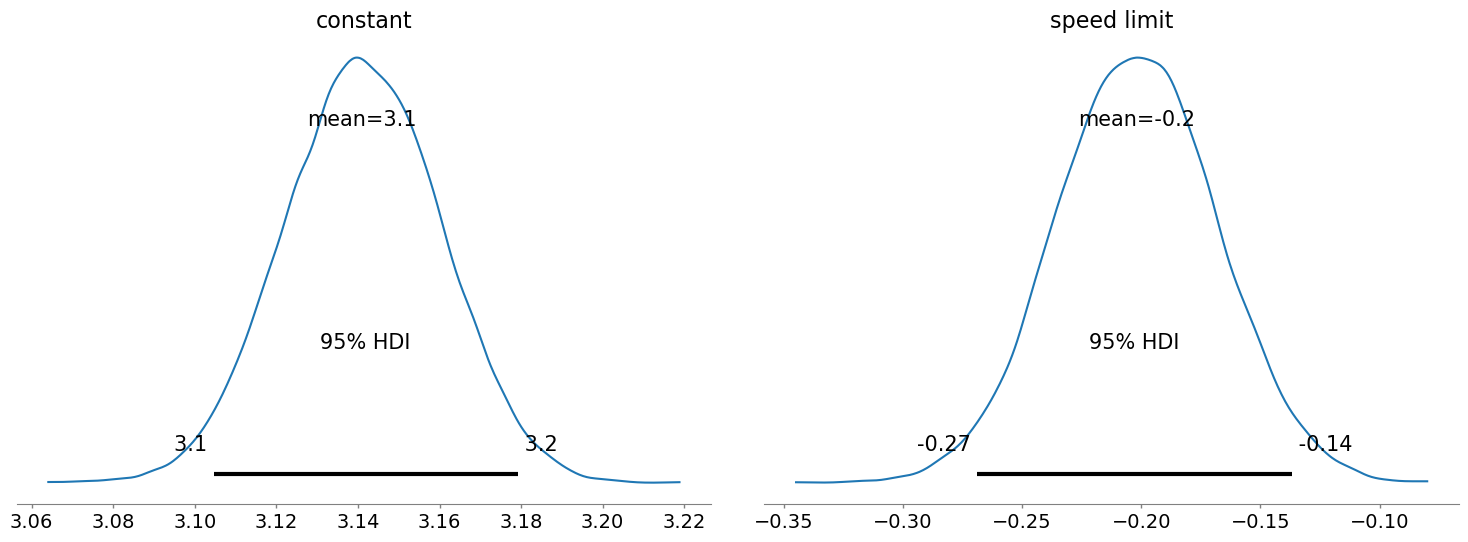

In [10]:
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean', hdi_prob=0.95)
plt.tight_layout()
plt.show()